In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_ds = ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Train', tt.Compose([transforms.Resize(224),tt.ToTensor()]))
val_ds = ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Validation', tt.Compose([transforms.Resize(224),tt.ToTensor()]))
test_ds = ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Test', tt.Compose([transforms.Resize(224),tt.ToTensor()]))

In [3]:
input_size=3*224*224

In [4]:
batch_size = 128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
class FaceMask(nn.Module):
    def __init__(self, input_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 784)
        self.linear2 = nn.Linear(784, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128,out_size)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [9]:
def train(epochs, model, train_loader, val_loader, optimizer):
    history = []
    min = float('inf')
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        print(result)
        if min > result['val_loss']:
            min = result['val_loss']
            torch.save(model.state_dict(), PATH)
        history.append(result)
    return history

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
model = FaceMask(input_size, 2)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [11]:
PATH = './content'

In [19]:
torch.save(model.state_dict(), PATH)

In [12]:
print(input_size)

150528


In [15]:
import torch.optim as optim 
optimizer = optim.Adam(model.parameters())

In [16]:
history = train(10, model, train_loader, val_loader, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_loss': 0.26393720507621765, 'val_acc': 0.9017857313156128}
{'val_loss': 0.20494391024112701, 'val_acc': 0.9241071343421936}
{'val_loss': 0.2874149978160858, 'val_acc': 0.8816964030265808}
{'val_loss': 0.14782120287418365, 'val_acc': 0.9508928656578064}
{'val_loss': 0.3721139132976532, 'val_acc': 0.8258928656578064}
{'val_loss': 0.0983857661485672, 'val_acc': 0.9709821343421936}
{'val_loss': 0.15932407975196838, 'val_acc': 0.9352678656578064}
{'val_loss': 0.09770006686449051, 'val_acc': 0.9598214030265808}
{'val_loss': 0.09799474477767944, 'val_acc': 0.9598214030265808}
{'val_loss': 0.3821583390235901, 'val_acc': 0.890625}


In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [18]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
evaluate(model,val_loader)

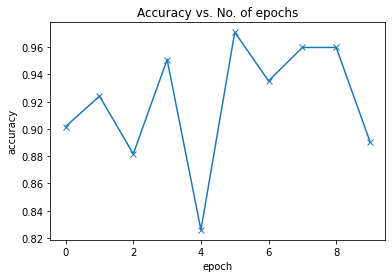

In [19]:
plot_accuracies(history)

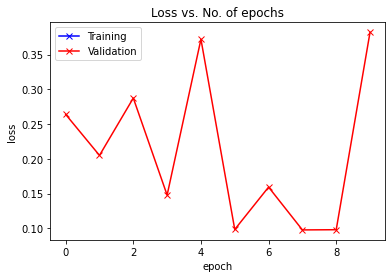

In [20]:
plot_losses(history)

In [21]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    if preds[0].item() == 0:
      print("Wearing Mask")
    else:
      print("Not Wearing Mask")

Not Wearing Mask


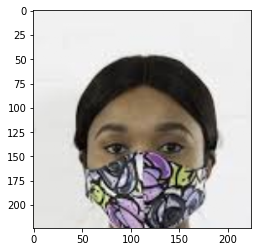

In [22]:
img,lab = test_ds[9]
predict_image(img, model)
plt.imshow(img.permute((1,2,0)))